# Find Payroll to Agency as Percentage of Total
Our methodology for the municipal agencies relies on using % of total payroll as a proxy for % of total pension payouts. This notebook will compare these two measures for state agencies to see how close they are

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sodapy import Socrata
app_token = "2Qa1WiG8G4kj1vGVd2noK7zP0"
client = Socrata("cthru.data.socrata.com", app_token)
client.timeout = 40

In [3]:
import pandas as pd
import sys
import os

In [4]:
sys.path.insert(0, "/Users/alexanderweinstein/Documents/Harris/Summer2020/Carceral_Budgeting/Exploratory")
from Initialize_Agencies_3Ver import get_agencies

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/alexanderweinstein/Documents/Harris/Summer2020/Carceral_Budgeting/Exploratory/pensions/State_Pensions_2Ver.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [5]:
sys.path.insert(0, "/Users/alexanderweinstein/Documents/Harris/Summer2020/Carceral_Budgeting/Exploratory/pensions")
from State_Pensions_2Ver import by_agency, get_cthru_pension_payouts, as_pcnt_of_total
pensions_statewide = by_agency(False)
state_pension_payouts = get_cthru_pension_payouts(False)
payout_pcnt = as_pcnt_of_total(state_pension_payouts, False)

In [6]:
yr = list(range(2016,2020))
agencies = get_agencies(yr)

/Users/alexanderweinstein/Documents/Harris/Summer2020/Carceral_Budgeting/Exploratory/Agency_Classes_2Ver.py:161: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  self.get_expenditures_by_year()
/Users/alexanderweinstein/Documents/Harris/Summer2020/Carceral_Budgeting/Exploratory/Agency_Classes_2Ver.py:161: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  self.get_expenditures_by_year()


### Load in payroll

In [7]:
total_payroll = pd.DataFrame(client.get("rxhc-k6iz", where = "year = 2019",  limit=9999999))

In [8]:
total_payroll.shape

(165509, 20)

In [9]:
total_payroll["pay_total_actual"] = total_payroll["pay_total_actual"].astype(float)

In [10]:
agencies.items()

dict_items([('trial_court', Agency object for trial_court), ('CPCS', Agency object for CPCS), ('DOC', Agency object for DOC), ('Suffolk DA', Agency object for Suffolk_DA), ('Suffolk Sheriff', Agency object for Suffolk_Sheriff), ('State_Police', Agency object for State_Police), ('MBTA', Agency object for MBTA), ('DAA', Agency object for DAA), ("MA Sheriff's Association", Agency object for MA Sheriff's Association), ('Parole Board', Agency object for Parole_Board), ('CJT', Agency object for CJT), ('Supreme_Judicial_Court', Agency object for Supreme_Judicial_Court), ('Appeals_Court', Agency object for Appeals_Court), ('Boston PD', Agency object for Boston PD), ('Chelsea PD', Agency object for Chelsea PD), ('Revere PD', Agency object for Revere PD), ('Winthrop PD', Agency object for Winthrop PD)])

In [11]:
payout_pcnt.index = payout_pcnt.index

In [12]:
def match_indexes(name):
    if name == "Suffolk DA":
        return "Suffolk_DA"
    if name == "Parole Board":
        return 

In [13]:
comparison_2019 = pd.DataFrame(columns = ["Pension Payouts Fraction", "Payroll Fraction", "Relative Difference" ])
for name, agency in agencies.items():
    if agency.alias in payout_pcnt.index:
        comparison_2019.loc[agency.alias,"Pension Payouts Fraction"] = payout_pcnt.loc[agency.alias, 2019]
        comparison_2019.loc[agency.alias, "Payroll Fraction"] = agency.payroll_by_year.loc["pay total actual", 2019]/total_payroll["pay_total_actual"].sum()
comparison_2019["Relative Difference"] = comparison_2019["Payroll Fraction"]/comparison_2019["Pension Payouts Fraction"]

In [14]:
# comparison_2019.to_csv("Compare_Pension_Payouts_and_Payroll_Fraction_Nov5.csv")

In [15]:
comparison_2019

,Pension Payouts Fraction,Payroll Fraction,Relative Difference
trial_court,0.050,0.066,1.305
CPCS,0.002,0.007,3.111
DOC,0.009,0.055,5.925
Suffolk_DA,0.001,0.002,2.412
Suffolk_Sheriff,0.005,0.011,2.014
State_Police,0.056,0.046,0.811
DAA,0.000,0.000,2.436
Parole_Board,0.004,0.002,0.541
Supreme_Judicial_Court,0.001,0.001,0.972
Appeals_Court,0.002,0.002,0.808


Ok so discrepancies here could be due to a number of things. One could be change in relative size of these agencies: if trial court employees 20 years ago made up a smaller portion of the statwide employee base then their realtive pension payouts will be lower compared to thier current payroll. Additionally the quality of the benefits package matters, presumably SCDAO employees have a less generous benefits package compared to thier yearly payroll.
The DOC difference is due to missing data.


For DOC, MBTA police there is missing data in the pension payouts in cthru. Do we use payroll fraction as a stand-in? We risk overestimating the share of the pension payouts but we have a strong argument that we are doing our best with the data we have available. Maybe that's content for a footnote. 

# Plot payroll as % of whole

Make sure to mention these are just 2019 numbers

In [16]:
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 18), "lines.linewidth": 5})
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

In [17]:
payroll_pcnt = comparison_2019["Payroll Fraction"]

In [18]:
payroll_pcnt.sum()

0.1904832909469229

In [19]:
payroll_pcnt.loc["Non-Carceral Payroll"] = 1 - payroll_pcnt.sum()

In [20]:
payroll_pcnt = payroll_pcnt[payroll_pcnt.values > .001]

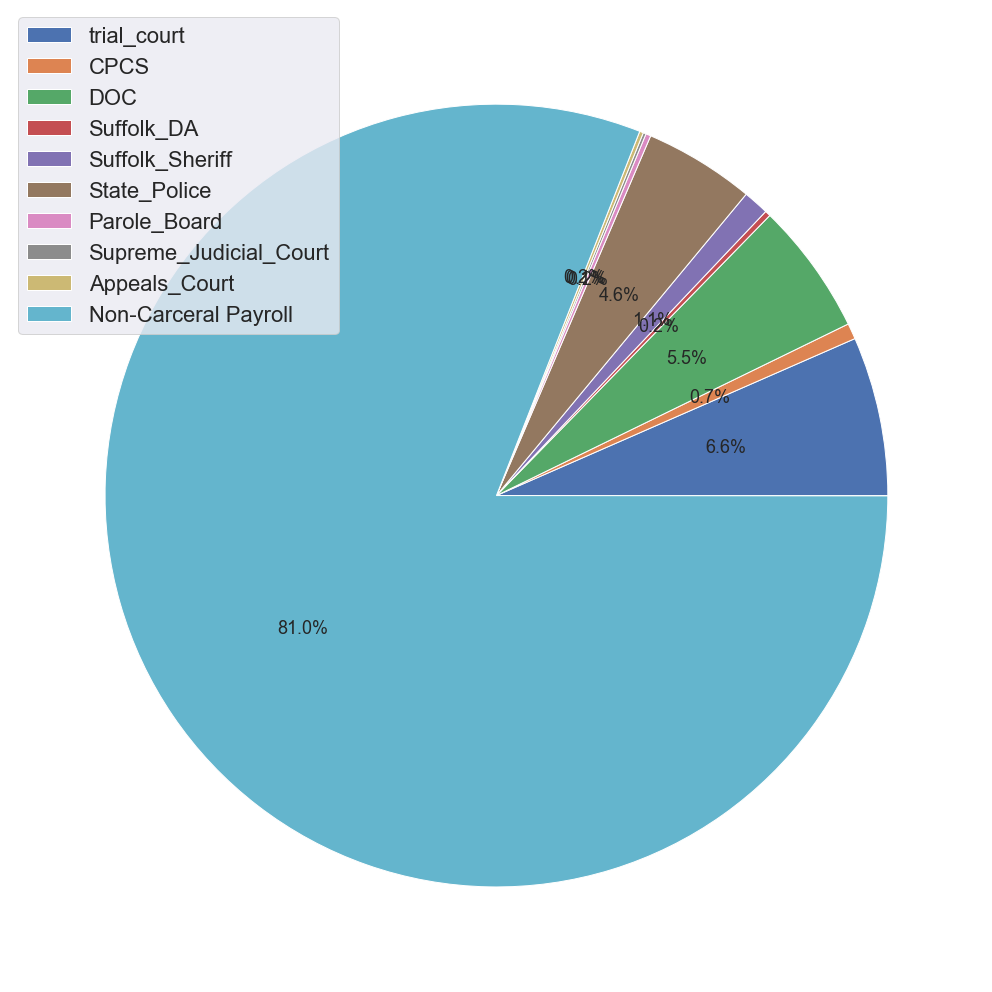

In [21]:
fig1, ax1 = plt.subplots()
ax1.pie(payroll_pcnt.values, autopct='%1.1f%%',  textprops={'fontsize': 18} )
ax1.legend(payroll_pcnt.index, prop={'size': 22})
fig1.savefig("Nov5_Figures/state_payroll_pcnt.png")

Next do carceral agencies only

In [22]:
payroll_pcnt_carceral = comparison_2019["Payroll Fraction"]

In [23]:
payroll_pcnt_carceral = payroll_pcnt_carceral/payroll_pcnt_carceral.sum()

In [24]:
payroll_pcnt_carceral

trial_court              0.066
CPCS                     0.007
DOC                      0.055
Suffolk_DA               0.002
Suffolk_Sheriff          0.011
State_Police             0.046
DAA                      0.000
Parole_Board             0.002
Supreme_Judicial_Court   0.001
Appeals_Court            0.002
Non-Carceral Payroll     0.810
Name: Payroll Fraction, dtype: object

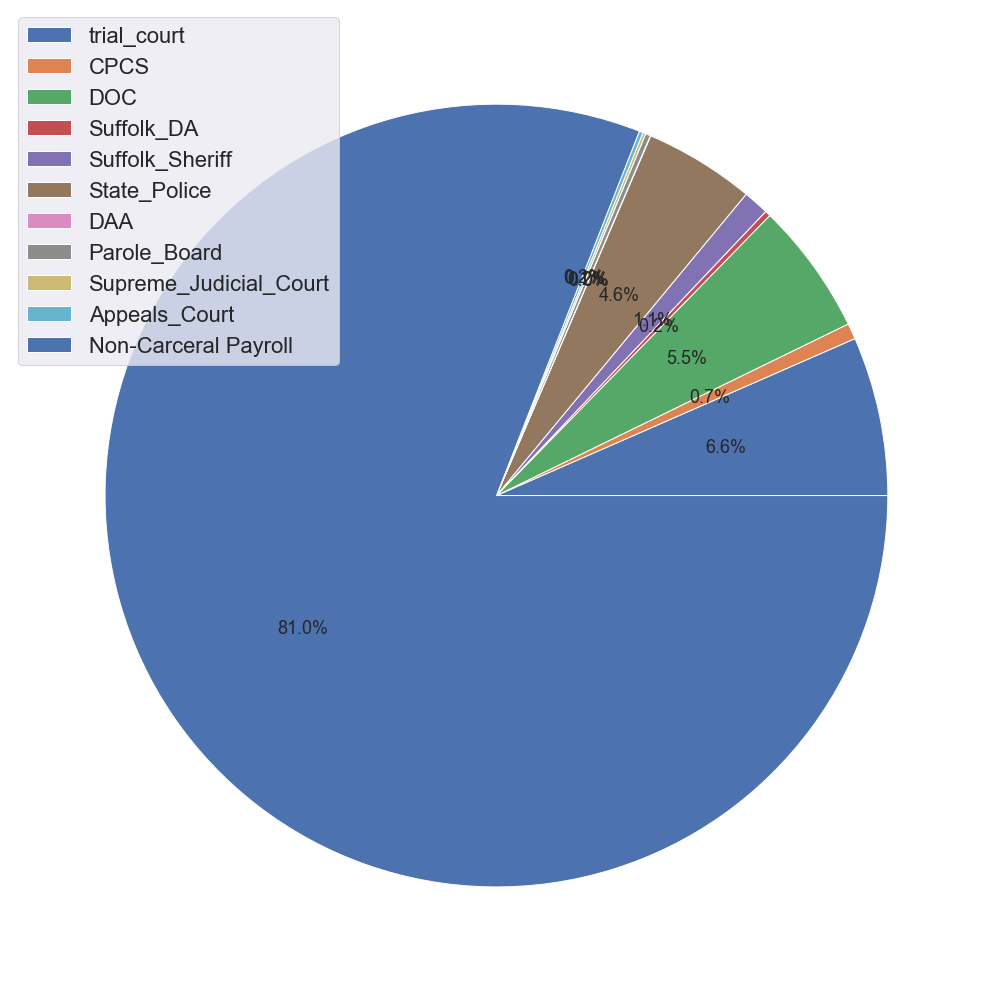

In [25]:
fig2, ax2 = plt.subplots()
ax2.pie(payroll_pcnt_carceral.values, autopct='%1.1f%%',  textprops={'fontsize': 18} )
ax2.legend(payroll_pcnt_carceral.index, prop={'size': 22})
fig2.savefig("Nov5_Figures/state_payroll_carceral_pcnt.png")